# Plot ApRES melt rates accross the channel profile at KIS2

I used /Users/home/whitefar/DATA/code/APRES/debug_melts.m to look at each melt rate profile and make sure they looked okay.
then /Users/home/whitefar/CODE/apres/apresBatchProcess.m to output KIS2_ApresResults.csv
using Matlab2019 running on co522pc01

## Large error in CP08
Definitely right file, cfg.polyorder=2 dont help. Moving the bed pick dont help.

In [1]:
import fiona
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
from shapely.geometry import Point
import numpy as np
import os
import sys
import glob
import matplotlib.pyplot as plt
from scipy import interpolate

from shapely.geometry import LineString


import rasterio as rio
import rasterio.mask
import matplotlib as mpl
import pickle


In [2]:
# df = pd.read_csv('/Users/home/whitefar/CODE/apres/KIS2_ApresResults.csv')
df = pd.read_csv('/Users/home/whitefar/DATA/ApRES/kis2_meltrates.csv')
df['meltRate'] = df.meltRate_v_Epoch1
# df = df.sort_values('x')
points = [Point(xy) for xy in zip(df.x,df.y) ]
gdf = gpd.GeoDataFrame(df,geometry=points,crs=3031)

In [3]:
gdfcc = df.query('(Epoch == 3) & cross_channel').copy()
gdfdc = df.query('(Epoch == 3) & down_channel').copy()
# gdfcc2 = df.query('(Epoch == 2) & cross_channel')

In [4]:
gdfcc.reset_index(drop=True,inplace=True)
gdfdc.reset_index(drop=True,inplace=True)


In [5]:
def add_distan_cum(gdf):
    tmp_dfp = [Point.distance(gdf.geometry.iloc[i]) for i,Point in enumerate(gdf.geometry.iloc[1:])]
    tmp_dfp[:0] = [0]
    gdf['dx'] = pd.Series(tmp_dfp)
    gdf['distan_cum'] = gdf.dx.cumsum()

In [6]:
df.keys()

Index(['Date', 'utc_time', 'lat', 'lon', 'Approx_Depth', 'File_Name',
       'AF_Gain', 'Stacks', 'RF_Atten', 'Site_ID', 'Notes', 'APRES_unit',
       'Epoch', 'meltRate', 'meltRateError', 'bed', 'dhStrain', 'dheStrain',
       'cross_channel', 'down_channel', 'x', 'y', 'meltRate_v_Epoch1',
       'migrated_res_thickness_at_apres_sites', 'geometry'],
      dtype='object')

# plot where it is on map

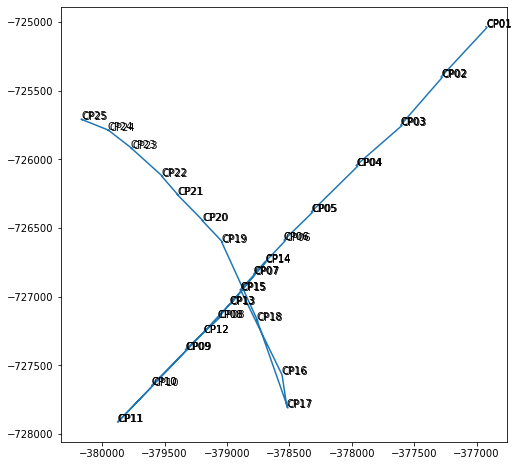

In [7]:
plt.figure(figsize=(8,8))
plt.plot(df.x,df.y)
for i in range(df.shape[0]):
    plt.annotate(df.Site_ID.tolist()[i],list(zip(df.x,df.y))[i])
plt.show()

In [8]:
res_bed_cross = gpd.read_file('/Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/picked_bed.shp').query('line_name == "lineAPREScross"')
res_bed_down = gpd.read_file('/Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/picked_bed.shp').query('line_name == "lineAPRESdown"')                                                                                                              


In [9]:
res_bed_cross.reset_index(drop=True,inplace=True)
res_bed_down.reset_index(drop=True,inplace=True)

In [10]:
add_distan_cum(res_bed_cross)
add_distan_cum(res_bed_down)

In [11]:
res_bed_cross.keys()

Index(['CDP', 'x', 'y', 'DELAY', 'line_name', 'surf', 'SEQnum', 'camp',
       'time_UTC', 'ice_thickn', 'bed', 'geometry', 'dx', 'distan_cum'],
      dtype='object')

In [12]:
fresbedcross = interpolate.interp1d(res_bed_cross.x,res_bed_cross.bed)
gdfcc_res_x = np.linspace(res_bed_cross.x.min(),res_bed_cross.x.max(),1000)
gdfcc_res_bed = fresbedcross(gdfcc_res_x)

In [13]:
fdistan_cumcross = interpolate.interp1d(res_bed_cross.x,res_bed_cross.distan_cum)
gdfcc_res_distan_cum = fdistan_cumcross(gdfcc_res_x)
gdfcc['distan_cum'] = fdistan_cumcross(gdfcc.x)

In [14]:
#this was used to give to craig
# fresbedcross = interpolate.interp1d(res_bed_cross.x,res_bed_cross.ice_thickn)
# gdfcc['res_thickn'] = fresbedcross(gdfcc.x-15)
# gdfcc.loc[:,['Site_ID','res_thickn']].to_csv('/Users/home/whitefar/DATA/ApRES/migrated_res_thickness_at_apres_sites.csv')

In [15]:
fresbeddown = interpolate.interp1d(res_bed_down.x,res_bed_down.bed)
gdfdc_res_x = np.linspace(gdfdc.x.min()-200,gdfdc.x.max()+200,1000)
gdfdc_res_bed = fresbeddown(gdfdc_res_x)

In [16]:
fdistan_cumdown = interpolate.interp1d(res_bed_down.x,res_bed_down.distan_cum-2000)
gdfdc_res_distan_cum = fdistan_cumdown(gdfdc_res_x)
gdfdc['distan_cum'] = fdistan_cumdown(gdfdc.x)

# Plot with the surface as well

In [17]:
df.keys()

Index(['Date', 'utc_time', 'lat', 'lon', 'Approx_Depth', 'File_Name',
       'AF_Gain', 'Stacks', 'RF_Atten', 'Site_ID', 'Notes', 'APRES_unit',
       'Epoch', 'meltRate', 'meltRateError', 'bed', 'dhStrain', 'dheStrain',
       'cross_channel', 'down_channel', 'x', 'y', 'meltRate_v_Epoch1',
       'migrated_res_thickness_at_apres_sites', 'geometry'],
      dtype='object')

In [18]:
radar_APREScross = gpd.read_file('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/lineAPREScross.shp')
radar_APREScross.keys()

Index(['timestamp', 'height', 'dt', 'velocity', 'acc', 'dx', 'distan_cum',
       'nid_122088', 'nid_131225', 'nid_131226', 'nid_131228', 'nid_145073',
       'nid_159199', 'nid_159200', 'nid_159202', 'geometry'],
      dtype='object')

In [19]:
radar_APRESdown = gpd.read_file('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/lineAPRESdown.shp')
radar_APRESdown.keys()

Index(['timestamp', 'height', 'dt', 'velocity', 'acc', 'dx', 'distan_cum',
       'nid_122088', 'nid_131225', 'nid_131226', 'nid_131228', 'nid_145073',
       'nid_145074', 'nid_159199', 'nid_159200', 'nid_159202', 'geometry'],
      dtype='object')

In [20]:
fsurfdown = interpolate.interp1d(radar_APRESdown.geometry.x,radar_APRESdown.height)
gdfdc_surf_bed = fsurfdown(gdfdc_res_x)

In [21]:
fsurfdown_cumdown = interpolate.interp1d(res_bed_down.x,res_bed_down.distan_cum)
gdfdc_surf_distan_cum = fdistan_cumdown(gdfdc_res_x)

In [22]:
f = interpolate.interp1d(radar_APREScross.geometry.x,radar_APREScross.height)
surf_fordepth = f(gdfcc.x)

In [23]:
startat=130
f2 = interpolate.interp1d(radar_APRESdown.geometry.x.iloc[startat:],radar_APRESdown.height.iloc[startat:])
surf_fordepth2 = f2(gdfdc.x)

In [24]:
with open('/Users/home/whitefar/DATA/global_corrections.pkl',"rb") as f2:
    correct = pickle.load(f2)
geoid_correction = correct['geoid_correction']
res_correction = correct['res_correction']
apres_firn = correct['apres_firn']

In [25]:
# xgrid = np.arange(gdfcc_res_distan_cum[],-374000,1000)

In [26]:
radar_APREScross.keys()

Index(['timestamp', 'height', 'dt', 'velocity', 'acc', 'dx', 'distan_cum',
       'nid_122088', 'nid_131225', 'nid_131226', 'nid_131228', 'nid_145073',
       'nid_159199', 'nid_159200', 'nid_159202', 'geometry'],
      dtype='object')

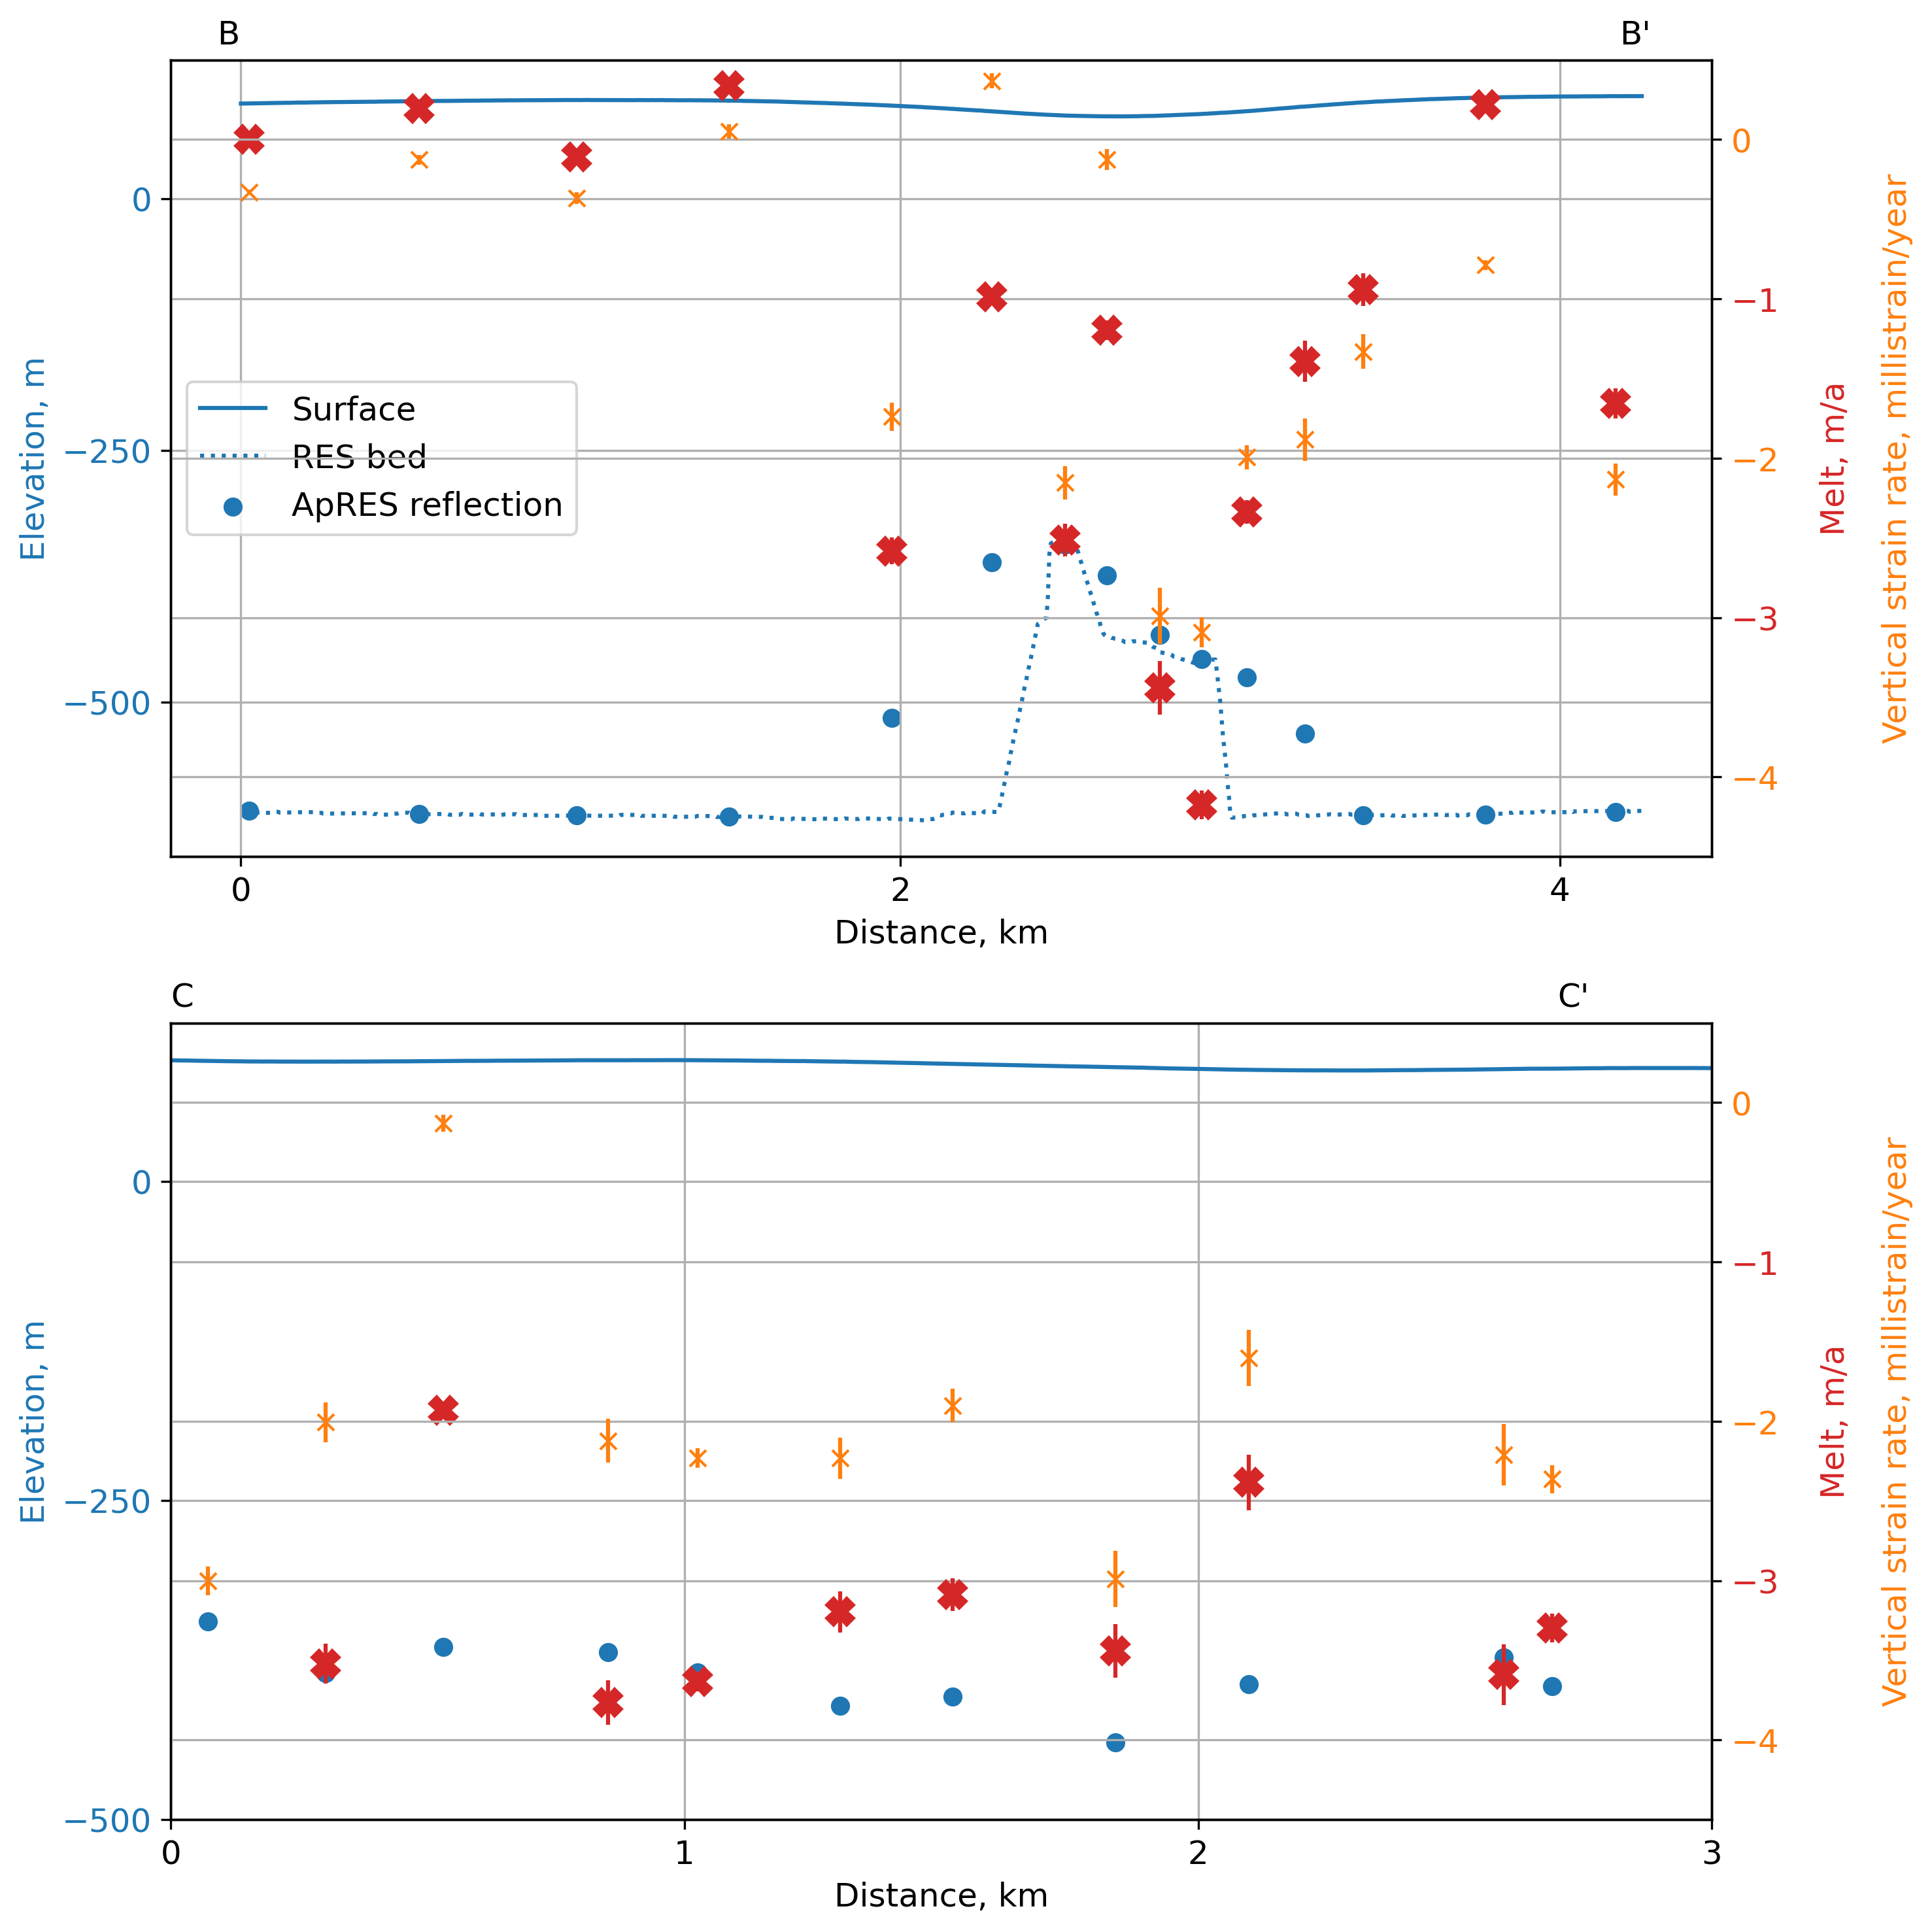

In [27]:
#https://matplotlib.org/3.1.1/gallery/ticks_and_spines/multiple_yaxis_with_spines.html
font = {'size'   : 12}

mpl.rc('font', **font)

fig, [ax1,axb] = plt.subplots(2,1,figsize=(10,10),dpi=300)
color = 'tab:blue'
ax1.set_xlabel('Distance, km')
ax1.set_ylabel('Elevation, m', color=color)
ax1.plot(radar_APREScross.distan_cum/1000,radar_APREScross.height+geoid_correction, color=color,label='Surface')
ax1.plot(gdfcc_res_distan_cum/1000,gdfcc_res_bed +geoid_correction+res_correction, ':', color=color,label='RES bed')
ax1.scatter(gdfcc.distan_cum/1000,surf_fordepth - gdfcc.bed +geoid_correction+apres_firn, marker='o', color=color,label='ApRES reflection')
# ax1.scatter(gdf.iloc[-1].x/1000,surf_fordepth[-1] - gdf.iloc[-1].bed +geoid_correction, marker='o', color='pink',label='Base',s=6)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid()
ax1.set_yticks([-500,-250,0])
ax1.set_xticks([0,2,4])



ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Melt, m/a', color=color)  # we already handled the x-label with ax1
ax2.errorbar(gdfcc.distan_cum/1000,gdfcc.meltRate,yerr=gdfcc.meltRateError,xerr=0,marker='X', color=color,linestyle="None",markersize=10)
ax2.tick_params(axis='y', labelcolor=color)
ax2.grid()
# ax2.axhline(y=0,color='r',linestyle=':')
ax2.yaxis.set_label_coords(1.07, 0.5)
ax2.set_yticks([-3,-1])
ax2.set_ylim([-4.5,0.5])

ax3 = ax1.twinx() 

color = 'tab:orange'
ax3.set_ylabel('Vertical strain rate, millistrain/year', color=color)  # we already handled the x-label with ax1
ax3.yaxis.set_label_coords(1.11, 0.5)
ax3.errorbar(gdfcc.distan_cum/1000,gdfcc.dhStrain,yerr=gdfcc.dheStrain,xerr=0,marker='x', color=color,linestyle="None")
# ax3.scatter(gdf.x,gdf.vertical_strain_rate,marker='s', color=color)
ax3.tick_params(axis='y', labelcolor=color)
ax3.grid()
ax3.set_yticks([-4,-2,0])
ax3.set_ylim([-4.5,0.5])
# ax3.axhline(y=0,color='orange',linestyle=':')

plt.text(0.03,1.02,"B",transform=ax1.transAxes,)
plt.text(0.94,1.02,"B'",transform=ax1.transAxes,)


ax1.legend(loc= 'center left')
############################################################==========================================
#Bottom plot

color = 'tab:blue'
axb.set_xlabel('Distance, km')
axb.set_ylabel('Elevation, m', color=color)
axb.scatter(gdfdc.distan_cum/1000,surf_fordepth2 - gdfdc.bed +geoid_correction, marker='o', color=color)
axb.plot(gdfdc_surf_distan_cum/1000,gdfdc_surf_bed+geoid_correction + apres_firn, color=color,label='Surface')
axb.tick_params(axis='y', labelcolor=color)
axb.grid()
axb.set_xticks([0,1,2,3])
axb.set_xlim([0,3])
axb.set_yticks([-500,-250,0])


ax2b = axb.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2b.set_ylabel('Melt, m/a', color=color)  # we already handled the x-label with axb
ax2b.errorbar(gdfdc.distan_cum/1000,gdfdc.meltRate,yerr=gdfdc.meltRateError,xerr=0,marker='X', color=color,linestyle="None",markersize=10)
# ax2b.scatter(gdf.x,gdf.melt_rate,marker='s', color=color)
ax2b.tick_params(axis='y', labelcolor=color)
ax2b.grid()
# ax2b.axhline(y=0,color='r',linestyle=':')
ax2b.yaxis.set_label_coords(1.07, 0.5)
ax2b.set_yticks([-3,-1])
ax2b.set_ylim([-4.5,0.5])




ax3b = axb.twinx() 

color = 'tab:orange'
ax3b.set_ylabel('Vertical strain rate, millistrain/year', color=color)  # we already handled the x-label with axb
ax3b.yaxis.set_label_coords(1.11, 0.5)
ax3b.errorbar(gdfdc.distan_cum/1000,gdfdc.dhStrain,yerr=gdfdc.dheStrain,xerr=0,marker='x', color=color,linestyle="None")
# ax3b.scatter(gdf.x,gdf.vertical_strain_rate,marker='s', color=color)
ax3b.tick_params(axis='y', labelcolor=color)
ax3b.grid()
ax3b.set_yticks([-4,-2,0])
ax3b.set_ylim([-4.5,0.5])
# ax3b.axhline(y=0,color='orange',linestyle=':')

plt.text(0.0,1.02,"C",transform=axb.transAxes)
plt.text(0.9,1.02,"C'",transform=axb.transAxes)

# axb.text(-0.1, 0.0, 'B', transform=axb.transAxes, 
#             size=25, weight='bold')


# axb.legend(loc= 'upper right')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.savefig('/Users/home/whitefar/ASSIGNMENTS-PUBLICATIONS-TALKS/channel_data_writeup/PLOTS/APRES_melt.png')

plt.show()

NameError: name 'xgrid' is not defined

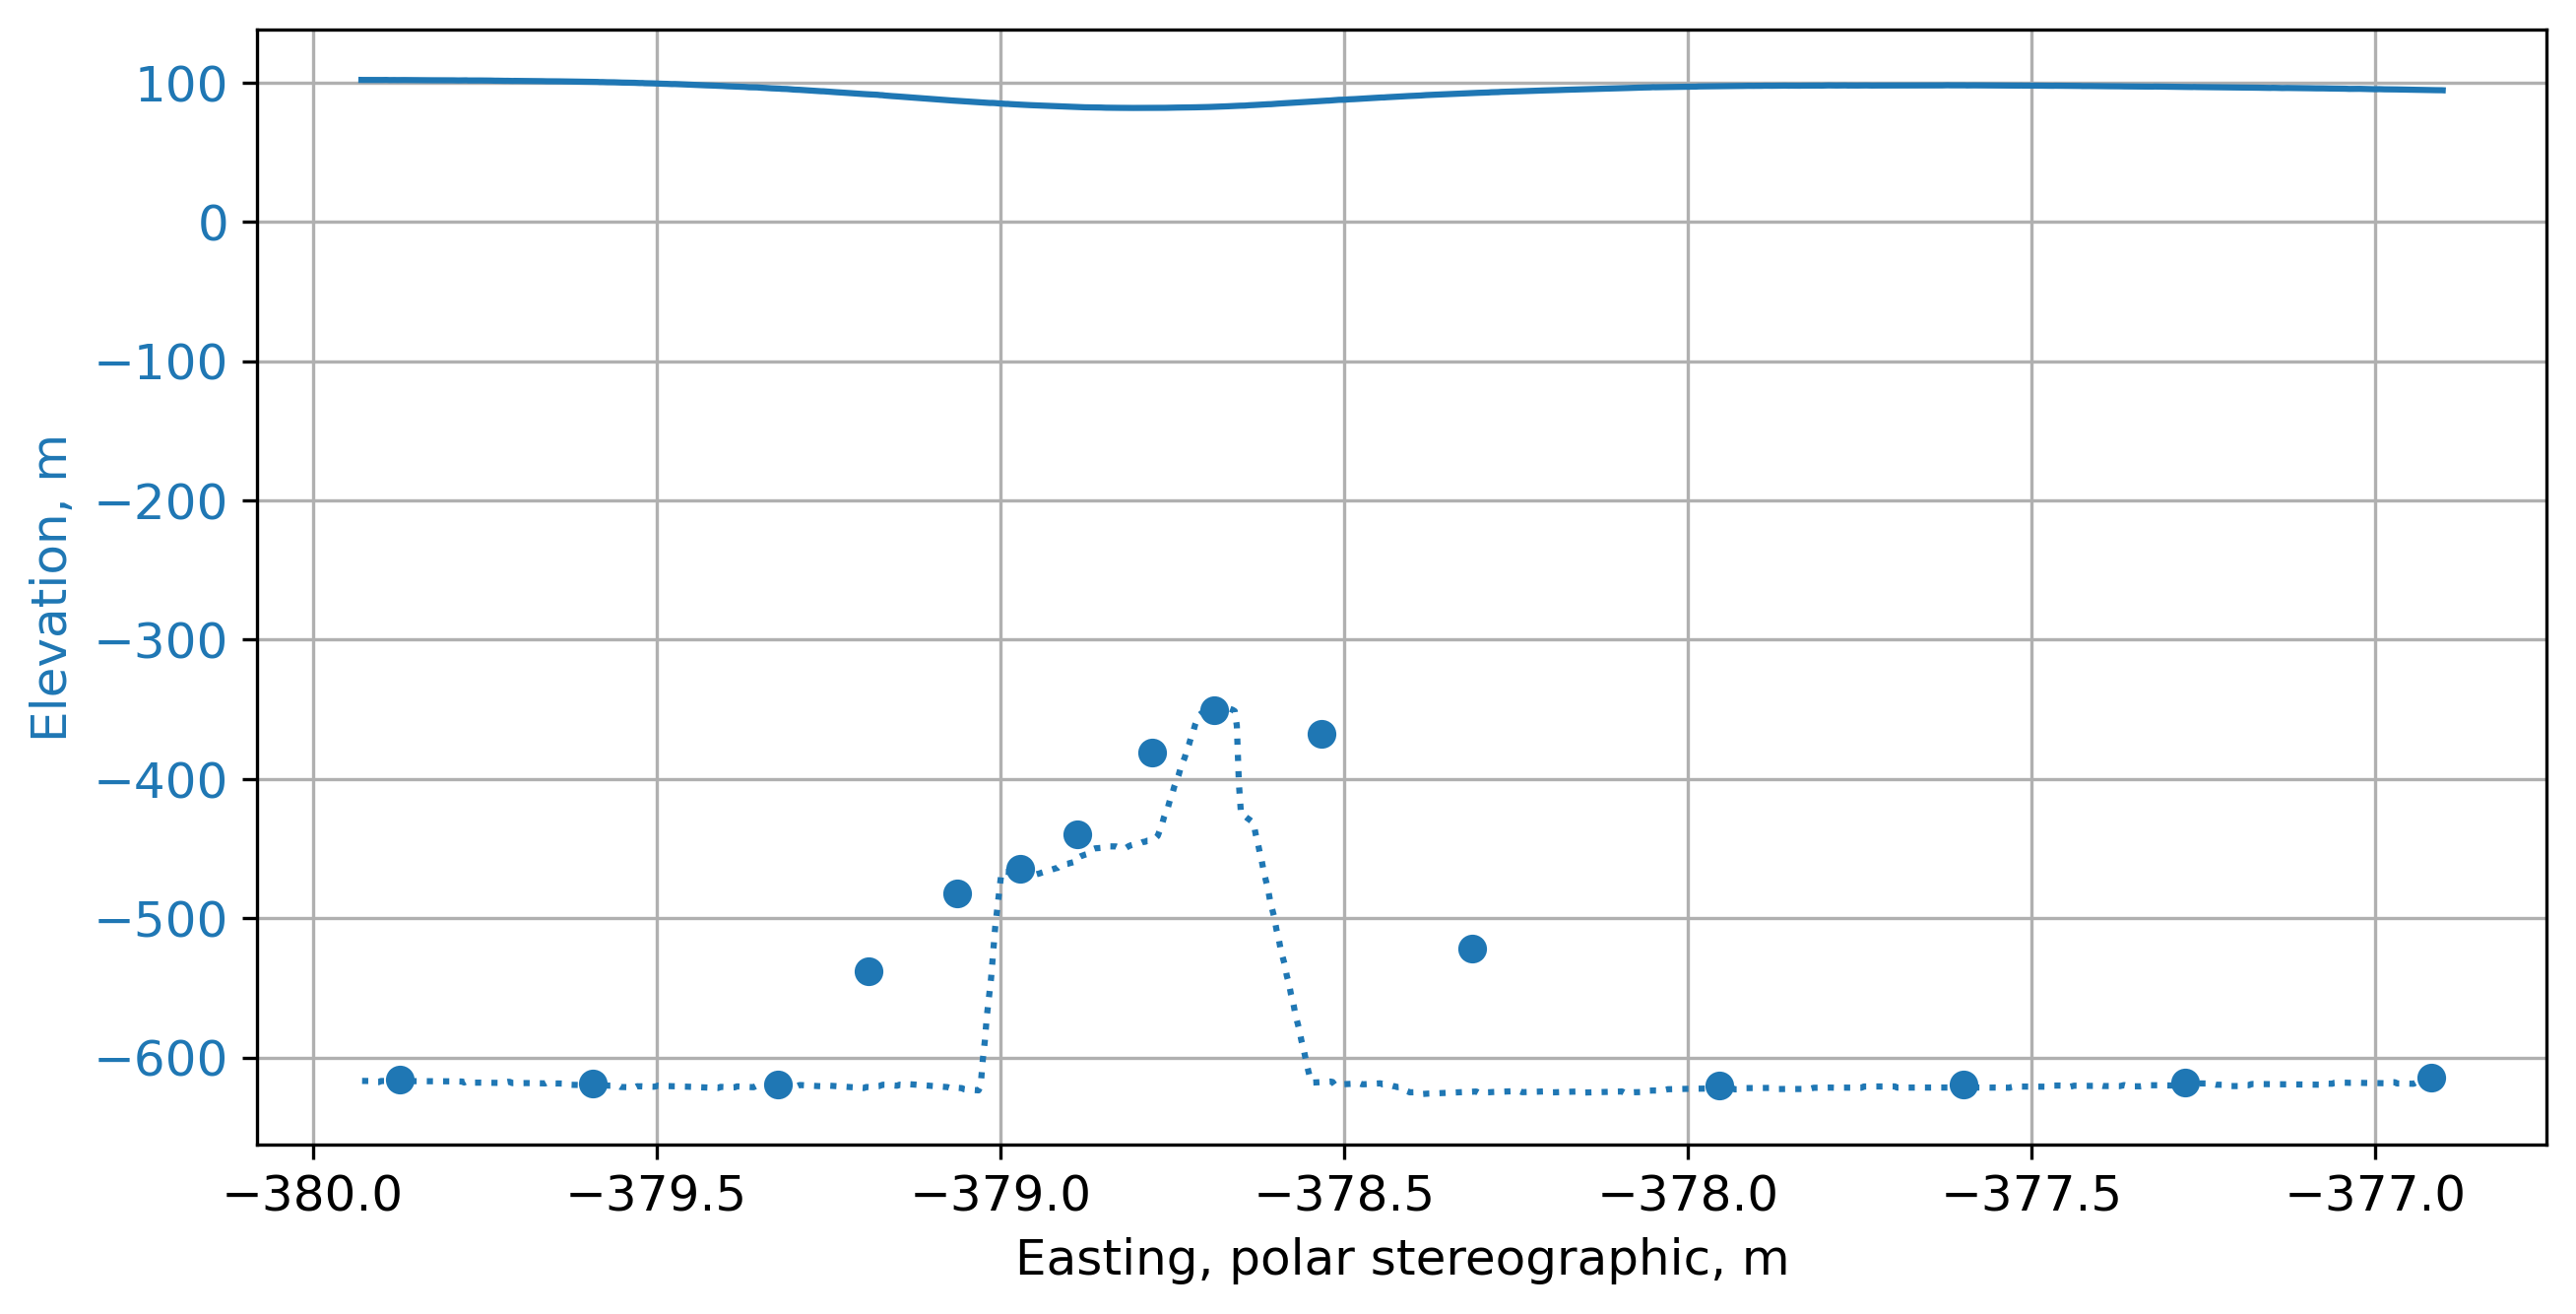

In [27]:
#https://matplotlib.org/3.1.1/gallery/ticks_and_spines/multiple_yaxis_with_spines.html
font = {'size'   : 12}

mpl.rc('font', **font)

fig, ax1 = plt.subplots(1,1,figsize=(10,5),dpi=300)
color = 'tab:blue'
ax1.set_xlabel('Easting, polar stereographic, m')
ax1.set_ylabel('Elevation, m', color=color)
ax1.plot(radar_APREScross.geometry.x/1000,radar_APREScross.height+geoid_correction, color=color,label='Surface')
ax1.plot(gdfcc_res_x/1000,gdfcc_res_bed +geoid_correction-16, ':', color=color,label='RES bed')
ax1.scatter(gdfcc.x/1000,surf_fordepth - gdfcc.bed +geoid_correction, marker='o', color=color,label='ApRES reflection')
# ax1.scatter(gdf.iloc[-1].x/1000,surf_fordepth[-1] - gdf.iloc[-1].bed +geoid_correction, marker='o', color='pink',label='Base',s=6)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid()
ax1.set_xticks(xgrid/1000)
ax1.set_ylim([-650, -300])


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Melt, m/a', color=color)  # we already handled the x-label with ax1
ax2.errorbar(gdfcc.x/1000,gdfcc.meltRate,yerr=gdfcc.meltRateError,xerr=0,marker='x', color=color,linestyle="None")
# ax2.errorbar(gdf2.x/1000,gdf2.meltRate+1,yerr=gdf2.meltRateError,xerr=0,marker='1', color=color,linestyle="None")
ax2.tick_params(axis='y', labelcolor=color)
ax2.grid()
ax2.axhline(y=0,color='r',linestyle=':')
ax2.yaxis.set_label_coords(1.07, 0.5)

ax3 = ax1.twinx() 

color = 'tab:orange'
ax3.set_ylabel('Vertical strain rate, millistrain/year', color=color)  # we already handled the x-label with ax1
ax3.yaxis.set_label_coords(1.11, 0.5)
ax3.errorbar(gdfcc.x/1000,gdfcc.dhStrain,yerr=gdfcc.dheStrain,xerr=0,marker='x', color=color,linestyle="None")
# ax3.scatter(gdf.x,gdf.vertical_strain_rate,marker='s', color=color)
ax3.tick_params(axis='y', labelcolor=color)
ax3.grid()
ax3.set_yticks([-3,-2,-1,0.5])
ax3.set_ylim([-3.5,0.5])
ax3.axhline(y=0,color='orange',linestyle=':')

ax1.text(-0.1, 0.8, 'A', transform=ax1.transAxes, 
            size=25, weight='bold')

ax1.legend()
############################################################==========================================


plt.show()

# 
If I was interpreting this I’d be tempted to use the mean and variability of rates observed within the 30m after the first basal reflector as indicative of the uncertainty in the observations, rather than the (lower) formal error estimate.